# Interior points method for the LASSO problem

Name: Aubin TCHOÏ

## Theoretical analysis

We want to solve the following problem:

\begin{equation}
  \tag{LASSO}
  \min_w \frac{1}{2} \| Xw  - y \|_2^2 + \lambda \| w \|_1 
\end{equation}

We want to derive the dual problem of LASSO and format it as a general Quadratic Problem as follows:

\begin{align}
  \tag{QP}
  \min_v \hspace{.3cm} & v^TQv + p^Tv \\
  \text{subject to} \hspace{.3cm} & Av \preccurlyeq b
\end{align}

$\text{(LASSO)}$ is equivalent to the following problem:

\begin{align}
  \min_{w, z} \hspace{.3cm} & \frac{1}{2} \| z  - y \|_2^2 + \lambda \| w \|_1 \\
  \text{subject to} \hspace{.3cm} & z = Xw
\end{align}

The dual function of this problem is:

\begin{align}
  g(\nu) &= \inf_{w, z} \frac{1}{2} \| z  - y \|_2^2 + \lambda \| w \|_1 + \nu^T(Xw - z) \\
  &= \inf_z \big( \frac{1}{2} \| z  - y \|_2^2 - \nu^T z \big) + \inf_w \big( \lambda \| w \|_1 + \nu^T Xw \big)
\end{align}

We have:
\begin{align}
  \inf_z \frac{1}{2} \| z  - y \|_2^2 - \nu^T z &= \frac{1}{2} \| \nu \|_2^2 - \nu^T (y + \nu) \\
  &= -\frac{1}{2} \| \nu \|_2^2 - \nu^Ty
\end{align}

With the minimum reached for $z = y + \nu$. We also have:
$$
  \inf_w \lambda \| w \|_1 + \nu^T Xw = \begin{cases}
      0 & \text{if} \hspace{.3cm} \| X^T\nu \|_\infty \leq \lambda \\
      -\infty & \text{otherwise}
    \end{cases}
$$

When combining the two, we get the following dual problem for $\text{(LASSO)}$:

\begin{align}
  \max_\nu \hspace{.3cm} & -\frac{1}{2} \| \nu \|_2^2 -\nu^T y \\
  \text{subject to} \hspace{.3cm} & X^T\nu \preccurlyeq \lambda \mathbb{1}_{\mathbb{R}^n} \hspace{.2cm} \text{and} \hspace{.2cm} -X^T\nu \preccurlyeq \lambda \mathbb{1}_{\mathbb{R}^n}
\end{align}

Which is equivalent to solving:

\begin{align}
  \min_\nu \hspace{.3cm} & \frac{1}{2} \nu^T\nu + \nu^T y \\
  \text{subject to} \hspace{.3cm} & X^T\nu \preccurlyeq \lambda \mathbb{1}_{\mathbb{R}^n} \hspace{.2cm} \text{and} \hspace{.2cm} -X^T\nu \preccurlyeq \lambda \mathbb{1}_{\mathbb{R}^n}
\end{align}

We recognize a quadratic problem with $Q = \frac{1}{2} I$, $p = y$, $A = \left(
  \begin{array}{c|c}
  X^T \\ \hline{~}
  -X^T
  \end{array}\right) \in \mathbb{R}^{2n \times d}$ and $b = \lambda \mathbb{1}_{\mathbb{R}^{2n}}$.

## Numerical experiments

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from src import barr_method

### Implementation of the oracles

See `src.oracles.py`.

### Implementation of the numerical methods

See `src.algorithm.py`.

### Constants

In [8]:
# Dimensions of the problem
n = 20
d = 15

# Variables of the primal problem
np.random.seed(1)
X = np.random.rand(n, d)
y = np.random.rand(n, 1)
lambd = 10

# Variables of the dual problem
Q = 0.5 * np.eye(n)
p = y
A = np.vstack((X.T, -X.T))
b = lambd * np.ones((2 * d, 1))

### Runs and visualisation of the results

After using the barrier method to find optimal values for the dual problem we can use these values to find the optimal elements of the primal problem.

Indeed, we have strong duality for LASSO using Slater's condition, and we previously established that the infimum of the Lagrangian on the primal variables was reached on $z = y + \nu = Xw$. If $\nu^*$ is a solution for the dual problem we can obtain $w$ by solving $Xw = y + \nu^*$ (necessarily primal feasible).

Best choice of mu: 140



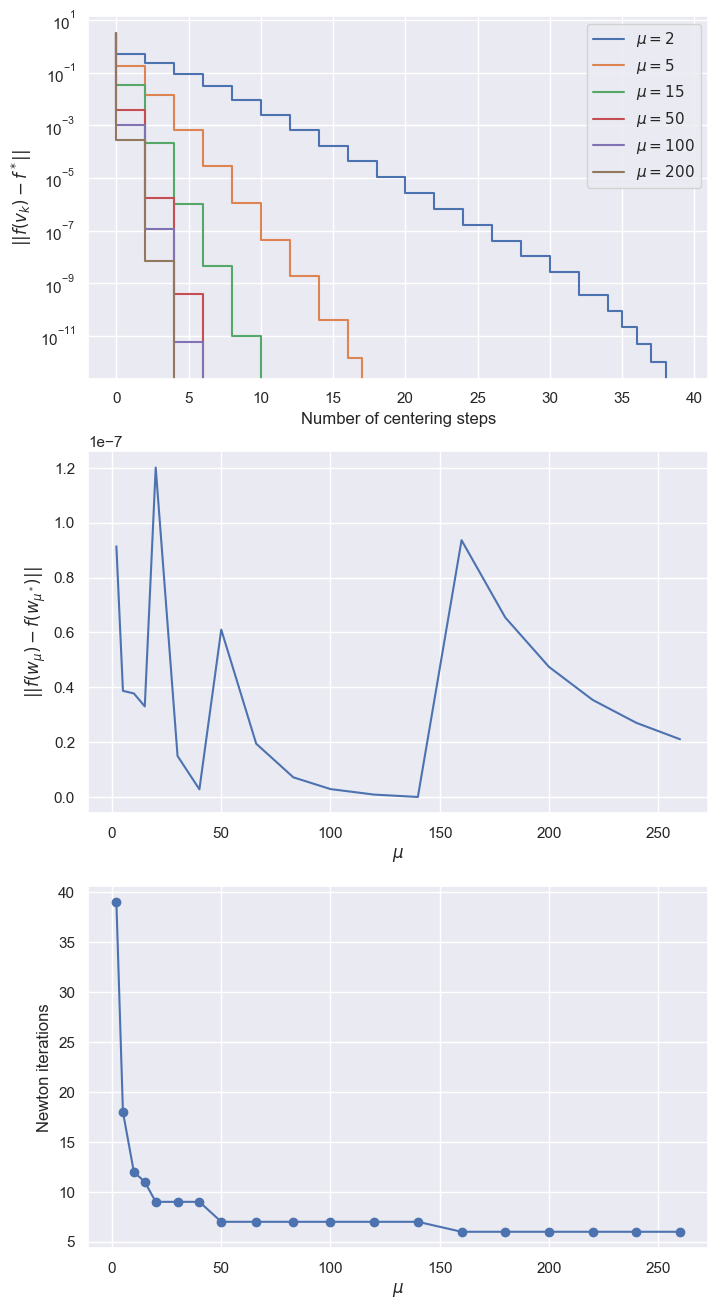

In [9]:
# Initialization of the method
v0 = np.zeros((n, 1))

mu_values = [
    2, 5, 10, 15, 20, 30, 40,
    50, 66, 83, 100, 120, 140,
    160, 180, 200, 220, 240, 260,
]
# only plotting the evolution of f over the iterations for these values of mu
mu_values_subset = {2, 5, 15, 50, 100, 200}
w_seq, f_values, newton_iteration_numbers = [], [], []

sns.set_theme()
fig, axs = plt.subplots(3, 1, figsize=(8, 16))

for mu in mu_values:
    newton_iter, v_seq, f_seq = barr_method(Q, p, A, b, v0, eps=1e-5, mu=mu)
    # going back to primal
    w_seq.append(np.linalg.lstsq(X, y + v_seq[-1], rcond=None)[0])
    f_values.append(f_seq[-1])
    newton_iteration_numbers.append(newton_iter[-1])
    if mu in mu_values_subset:
        axs[0].step(newton_iter, f_seq - f_seq[-1], label=f"$\mu = {str(mu)}$")

axs[0].set(xlabel="Number of centering steps", ylabel=r"$|| f(v_k) - f^* ||$", yscale="log")
axs[0].legend()

best_mu_idx = np.argmin(f_values)
print(f"Best choice of mu: {mu_values[best_mu_idx]}\n")
axs[1].plot(mu_values, [np.linalg.norm(w - w_seq[best_mu_idx]) for w in w_seq])
axs[1].set(xlabel=r"$\mu$", ylabel=r"$|| f(w_\mu) - f(w_{\mu^*}) ||$")

axs[2].plot(mu_values, newton_iteration_numbers, marker="o")
axs[2].set(xlabel=r"$\mu$", ylabel="Newton iterations")

plt.show()

When using low values of $\mu$ a lot of outer iterations (iterations of the barrier method in itself) are needed. Thankfully in our setting we do not need more inner iterations (centering step) to converge  when we increase the value of $\mu$.

However, depending on the value of $\mu$ we can get values of $w$ that are far (in norm) from the optimal value found over each choice of $\mu$. Therefore an appropriate choice for $\mu$ is one that minimizes this distance, in our setting we get $\mu^* = 120$.

The current implementation seems robust on the choice of $\mu$, however we get significantly different results when we perturb the value of $\epsilon$.